# HR Employee Churn ML Modeling

## Project Overview

The HR department at Nantucket Motors seeks to improve employee retention by understanding why employees might leave the company. The project goal is to analyze the data and build a predictive model that identifies employees likely to quit. By pinpointing key factors, in gathered employee data, that influence turnover — such as job satisfaction, compensation, workload — the company can implement targeted retention strategies. Ultimately, this data-driven approach will enhance employee satisfaction and reduce the costs associated with recruiting and onboarding new talent.

## Project Summary

10 departments in data

## HR Employee Dataset

Source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

# *Utilizing a PACE Framework* 
# Planning

- Stakeholders
    * HR department
- Trying to solve or accomplish?
    * How to increase employee retention: designing a model that predicts whether an employee will leave the company.
- Resources expected
    * scikit, pickle (for storing models), XG, matplot, seaborn
- Ethical or Security considerations?
    * Not currently - from the Data Dictionary, there doesn't seem to be any features (e.g. Gender) that may induce ethical considerations/concerns, and no PII that may be a security/privacy concern.
- Initial data observations (see *data.head()* below)
    * All of the features listed ostensibly seem like beneficial ones to include in analysis and modeling; we can check for multicollinearity, but i believe the classification models which will be intended for training (prior to champion selection) handle multicollinearity well, and we may not need to intervene if that is a present factor.



In [1]:
# Import packages
### YOUR CODE HERE ### 
import numpy as np
import pandas as pd

# import data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# import model helper creatoin & evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
        f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report 
from sklearn.model_selection import train_test_split, GridSearchCV

#import Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

import pickle


In [2]:
# load dataset into a dataframe
data = pd.read_csv("/kaggle/input/hr-analytics-and-job-prediction/HR_comma_sep.csv")

data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Data Exploration *(Initial EDA & Cleaning)*

- Interpreting initial observations
- Cleaning dataset - missing data, redundant data, outliers



In [3]:
# gathering basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
# checking unique Department values
data['Department'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

#### Basic Info Insights

* No Null Values for any features
* 10 different Business departments within dataset
* ~14.9k total rows
* 10 columns
* `Department` & `salary` are type `object` which we may want to encode
    * Salary is categorical - we may want to consider dropping this; or can leave it in for future consideration if there is notable relationship or predictive power. 
    * We may need clarification on salary ranges which make-up the relative categories of `low`, `medium`, `high`.

#### Encoding Considerations :
* Using one-hot encoding will allow our model(s) to understand categorical data in relationship to the whole dataset, vs. label encoding which will encode within the feature and limit the total understanding of the categories when compared to one another and the rest of the data's relative characteristics.
* As this is not a Linear Regression, we can't use ANOVA modeling to see if there are any relationships within the categorical features themselves & how much (if any) variation on our dependent, *left*, variable there may be.

In [5]:
# gathering descriptive stats
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


#### Descriptive Stats Insights
* May want to investigate:
    * `average_montly_hours` - the average value of this is ~41 hours greater than a typical 40-hour workweek's month, explicitly the course of 4 weeks (160 hours)
    * `promotion_last_5years` - there seems to be only one employee in this dataset which has received a promotion in the last 5 years
    * `number_project` - range is between 2-7 projects, with 3.8 being the average; there may be a relationship with employees having higher than avg. project amounts & whether or not they leave the company

### Renaming columns for efficiency

In [6]:
# gathering column names
data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [7]:
# dictionary for column replacement
replacement_dict = {'Department' : 'department',
                    'Work_accident' : 'work_accident',
                    'average_montly_hours' : 'average_monthly_hours'}

# column rename
data = data.rename(replacement_dict, axis=1)

In [8]:
# column validation to snake_case
data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

### Reviewing Missing Values & Duplicates

In [9]:
# sum of missing values
data.isna().any(axis=1).sum()

0

### Duplicates Check

In [10]:
# sum of duplicates
data.duplicated().sum()

3008

In [11]:
# inspecting rows containing duplicates
data.loc[data.duplicated(keep=False), :].head(10).sort_values(['number_project'])

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
2,0.11,0.88,7,272,4,0,1,0,sales,medium


#### Duplicates Evaluation

* Considering the dataset, duplicates are expected to be caused by variables where there isn't a ton of variance - as noted in basic descriptive metrics. In this case, there is no need to drop duplicates, as that may diminish the value of the data. As these 3008 records make-up 20% of the data, it is recommended not to drop duplicates.

### Outliers

#### Outlier Considerations

**Prior to modeling, we will want to remove/transform outliers, as Logistic Regression models assume no extreme outliers:**
* If not removal, can considering transforming outliers with upper/lower limit thresholds
* May need to take log of skewed features in order to normalize some features, depending on distribution of data

#### 1) Tenure

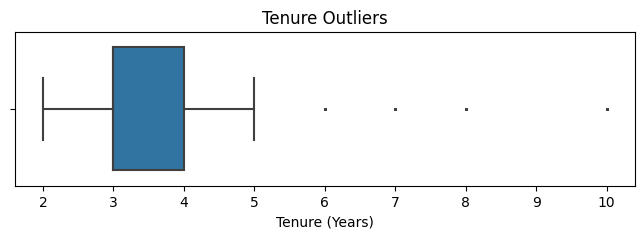

In [12]:
# boxplot to visualize/detect outliers for `time_spend_company`
fig, ax = plt.subplots(figsize=(8,2))
sns.boxplot(x=data['time_spend_company'], fliersize = 1)

plt.title('Tenure Outliers')
ax.set_xlabel('Tenure (Years)')

plt.show()

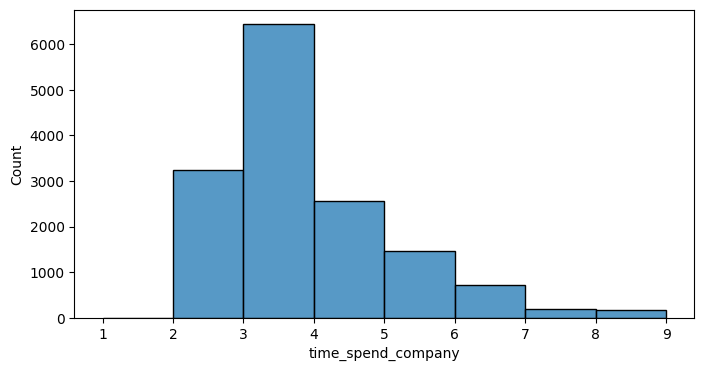

In [13]:
# histogram for distibution visual
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(data['time_spend_company'], bins=range(1,10,1))

plt.show()

#### 1a) Handling Tenure Outliers

In [14]:
# split tenure into 25th and 75th percentiles
percentile_75 = data['time_spend_company'].quantile(0.75)
percentile_25 = data['time_spend_company'].quantile(0.25)

# calculate iqr
iqr = percentile_75 - percentile_25

# determine upper limit
upper_limit_tenure = percentile_75 + 1.5 * iqr

# determine lower limit
lower_limit_tenure = percentile_25 -1.5 * iqr

#storing outliers & printing total number present
outliers_tenure = data[(data['time_spend_company'] > upper_limit_tenure) | (data['time_spend_company'] < lower_limit_tenure)]
print(f'Num of outliers: {len(outliers_tenure)}')

Num of outliers: 1282


In [15]:
# printing upper & lower limits
print(f'Upper limit: {upper_limit_tenure}')
print(f'Lower limit: {lower_limit_tenure}')

Upper limit: 5.5
Lower limit: 1.5


In [16]:
'''
This function replaces observations within the bounds of its upper and lower limits, as visualized via box & whisker plot 
'''
def outlier_handler(o : int, upper_limit, lower_limit):
    if o > upper_limit:
        o = upper_limit
    elif o < lower_limit:
        o = lower_limit
    else:
        o = o
    
    return o

In [19]:
# replacing outliers with relative upper limit
data['time_spend_company'] = data.time_spend_company.apply(outlier_handler, args=(upper_limit_tenure, lower_limit_tenure)).copy()

In [20]:
# outlier handling validation
data[(data.time_spend_company > upper_limit_tenure) | (data.time_spend_company < lower_limit_tenure)].count()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

#### 2) Promotion In Last 5 Yrs.

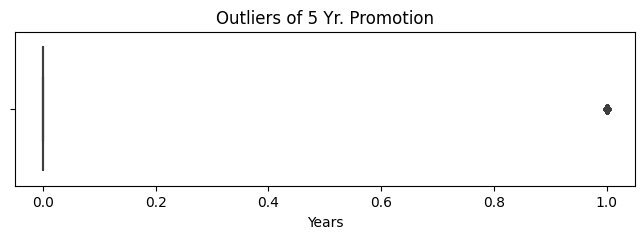

In [23]:
# boxplot to visualize/detect outliers for `promotion_last_5years`
fig, ax = plt.subplots(figsize=(8,2))
sns.boxplot(x=data['promotion_last_5years'])

plt.title('Outliers of 5 Yr. Promotion')
ax.set_xlabel('Years')

plt.show()

In [26]:
# count of employees that receieved promotion in last 5 yrs
data[(data['promotion_last_5years'] == 1)][['promotion_last_5years']].count() 

promotion_last_5years    319
dtype: int64

#### 'Promotion in last 5 Yrs.' Insights
* It's important to note that 2.12% of employees received a promotion in the last 5 years. While this is an extreme outlier, it is also a legitimate observation that represents an integral part of the population being studied, and is recommended to leave in the dataset.

#### 3) Average Monthly Hours *(No outliers)*

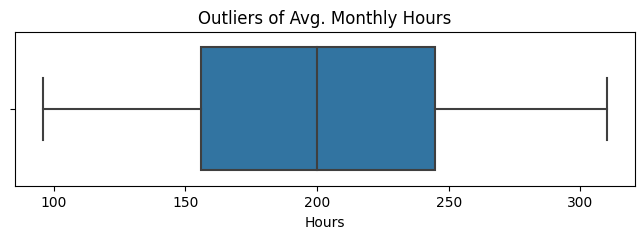

In [21]:
# boxplot to visualize/detect outliers for `average_monthly_hours`
fig, ax = plt.subplots(figsize=(8,2))
sns.boxplot(x=data['average_monthly_hours'])

plt.title('Outliers of Avg. Monthly Hours')
ax.set_xlabel('Hours')

plt.show()

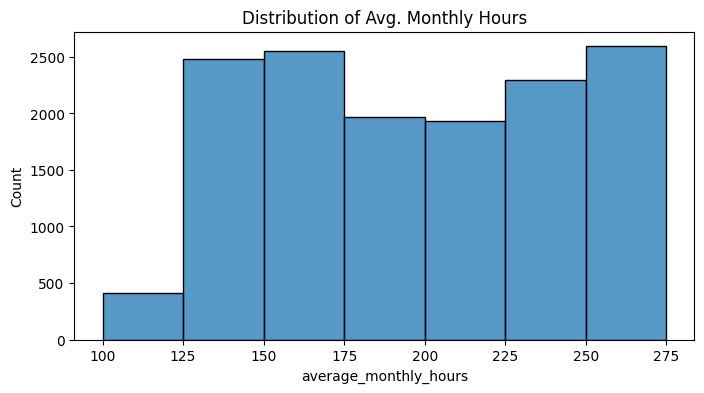

In [22]:
# histogram for distibution visual
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(data['average_monthly_hours'], bins=range(100,300,25))

plt.title('Distribution of Avg. Monthly Hours')
plt.show()

#### 4) Num. of Projects *(No outliers)*

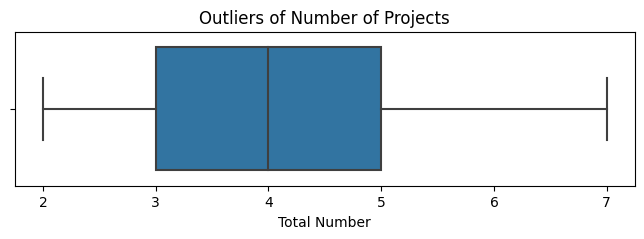

In [27]:
# boxplot to visualize/detect outliers for `number_project`
fig, ax = plt.subplots(figsize=(8,2))
sns.boxplot(x=data['number_project'])

plt.title('Outliers of Number of Projects')
ax.set_xlabel('Total Number')

plt.show()

#### 5) Satisfaction Level *(No outliers)*

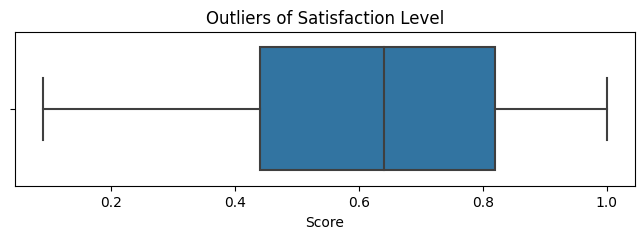

In [28]:
# boxplot to visualize/detect outliers for `satisfaction_level`
fig, ax = plt.subplots(figsize=(8,2))
sns.boxplot(x=data['satisfaction_level'])

plt.title('Outliers of Satisfaction Level')
ax.set_xlabel('Score')

plt.show()

#### 6) Last Evaluation *(No outliers)*

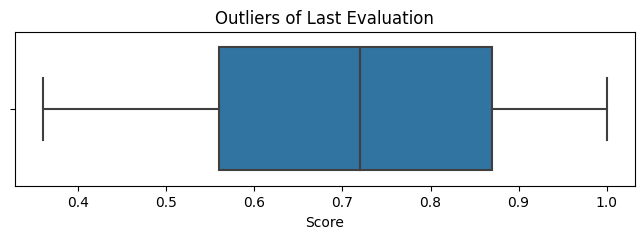

In [29]:
# boxplot to visualize/detect outliers for `last_evaluation`
fig, ax = plt.subplots(figsize=(8,2))
sns.boxplot(x=data['last_evaluation'])

plt.title('Outliers of Last Evaluation')
ax.set_xlabel('Score')

plt.show()

# Analyzing
- Performing continued/detailed EDA, *analyzing relationships between variables*
    - Currently no ethical or security considerations to take into account with features present in data, and intended use of data






## Goals

1. Understanding how many employees left and what percentage of all employees this figure represents.
2. Examining variables of interest, and creating plots to visualize relationships between variables in data.
3. Multicollinearity check

In [30]:
# number of people who stayed vs. left
data['left'].value_counts()

left
0    11428
1     3571
Name: count, dtype: int64

In [31]:
# percentage proportions of people who stayed vs. left
data['left'].value_counts(normalize=True)

left
0    0.761917
1    0.238083
Name: proportion, dtype: float64

## Multicollinearity Check

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


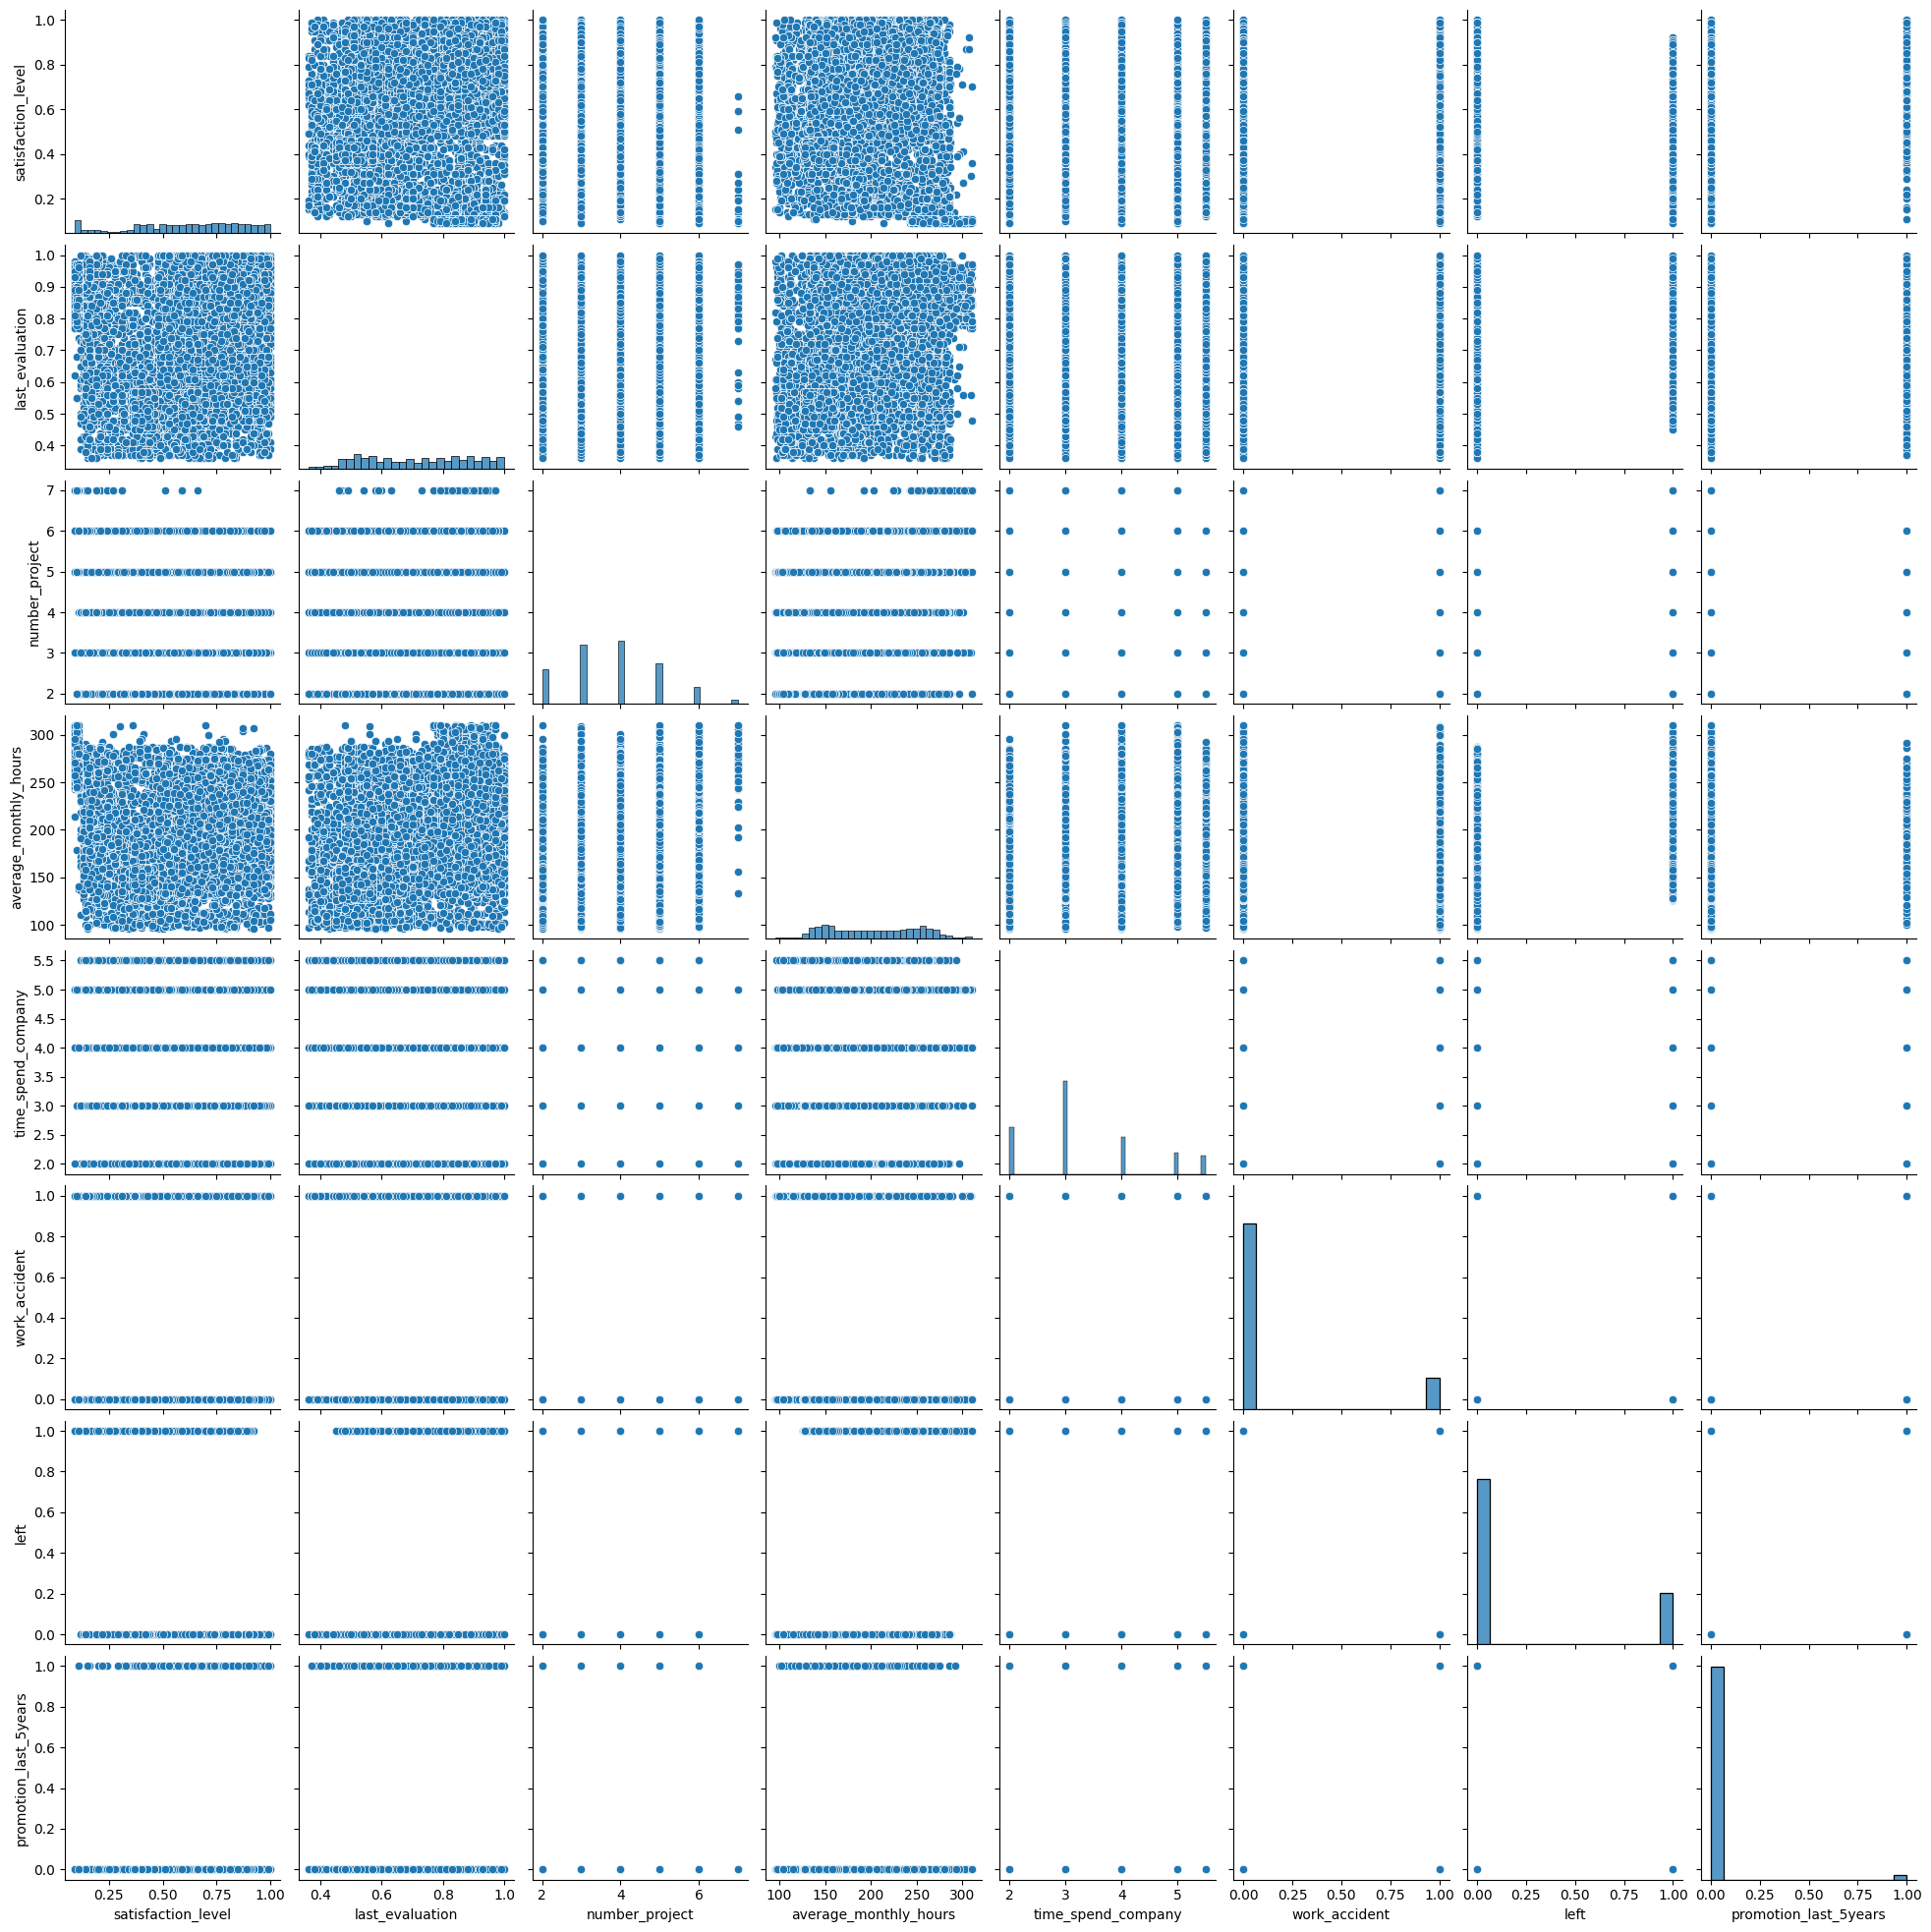

In [32]:
# pair-plot for visualizing any initial multicollinearity
sns.pairplot(data)

### Multicollinearity Insights

* There doesn't seem to be any individually strong linear correlations in the pairplot; but taking into consideration the binary nature of some features, a heatmap may help better depict correlation among features

## Visual Correlations

### Encoding 'salary'

- Encoding 'salary' to help better determine if any correlation exists with its inclusion
- Opted to not use `cat.codes` as this will arbitrarily apply numerical mappings to the categories 
    * `salary` hierarchy needs to be preserved - *a dictionary needs to be created and values manually assigned*
    * perform dummy mapping for `department` to avoid creating unintentional bias between departments by having an unintended ranking of numerics

In [33]:
salary_dict = {'low' : 1,
               'medium' : 2,
               'high' : 3}

data['salary_enc'] = data['salary'].replace(salary_dict)
data.head(2)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary,salary_enc
0,0.38,0.53,2,157,3.0,0,1,0,sales,low,1
1,0.80,0.86,5,262,5.5,0,1,0,sales,medium,2


In [34]:
# confirming groupings
data.groupby('salary')['salary_enc'].unique().sort_values()

salary
low       [1]
medium    [2]
high      [3]
Name: salary_enc, dtype: object

In [35]:
# creating subset of data with only numerical variables
data_subset = data[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company', 'work_accident', \
                    'left', 'promotion_last_5years', 'salary_enc']]
data_subset.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,salary_enc
0,0.38,0.53,2,157,3.0,0,1,0,1
1,0.80,0.86,5,262,5.5,0,1,0,2
2,0.11,0.88,7,272,4.0,0,1,0,2
3,0.72,0.87,5,223,5.0,0,1,0,1
4,0.37,0.52,2,159,3.0,0,1,0,1


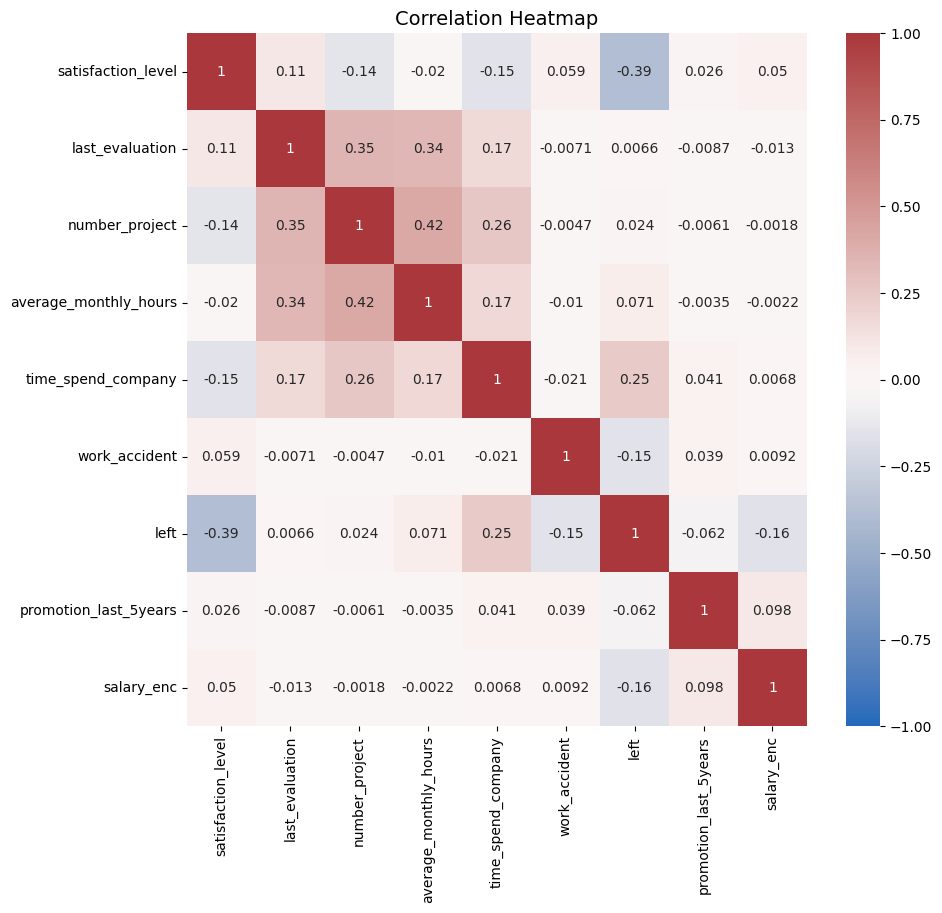

In [39]:
# correlation heatmap
plt.figure(figsize=(10, 9))
heatmap = sns.heatmap(data_subset.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
plt.title('Correlation Heatmap', fontsize=14)

plt.show()

### Heatmap Observations
* Number of projects to avg. monthly hours are positively correlated to a notable degree
* An employee's last evaluation score compared to the number of projects are positively correlated to a notable degree
    * Similarly, an employee's last evaluation compared to avg. monthly hours is nearly statistically the same as its comparison to an employee's number of projects
* An employee's number of projects seem to be negatively correlated with satisfaction level 
    * May want to investigate if a higher number of projects lead to a lesser satisfaction level
* The number of employees that left seem to be negatively correlated with satisfaction level
    * May want to investigate if a high satisfaction level is correlated with low counts of employees that left

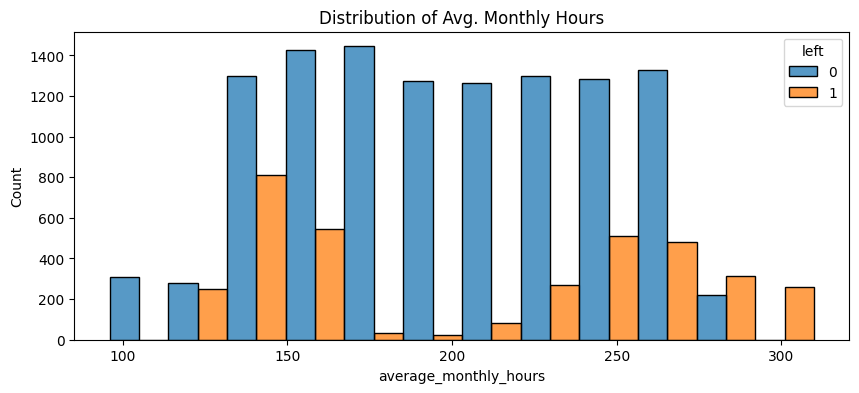

In [75]:
# histogram for distribution of avg. monthly hours
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=data_subset, x='average_monthly_hours', hue='left', multiple = 'dodge', bins=12)

plt.title('Distribution of Avg. Monthly Hours')
plt.show()

1. When looking at the 'Distribution of Avg. Monthly Hours', it is interesting to observe that employees that stayed, work between ~125-280 monthly hours. However, there are increases in employees that leave for hours worked ~125-175 and ~225-280. Although there is a larger uptick in the number of employees that stayed for a range of hours, it is important to note that 160 hours is a quintessential month at 40hrs/week - most employees are working above this average. It seems evident that the uptick in employees leaving the company, coincide with approaching the edge of 160hrs., and then tailors off until reaching the mid-200s. Nonetheless, it should be worthwhile to probe the correlation of average-monthly-hours & whether employees leave or not.


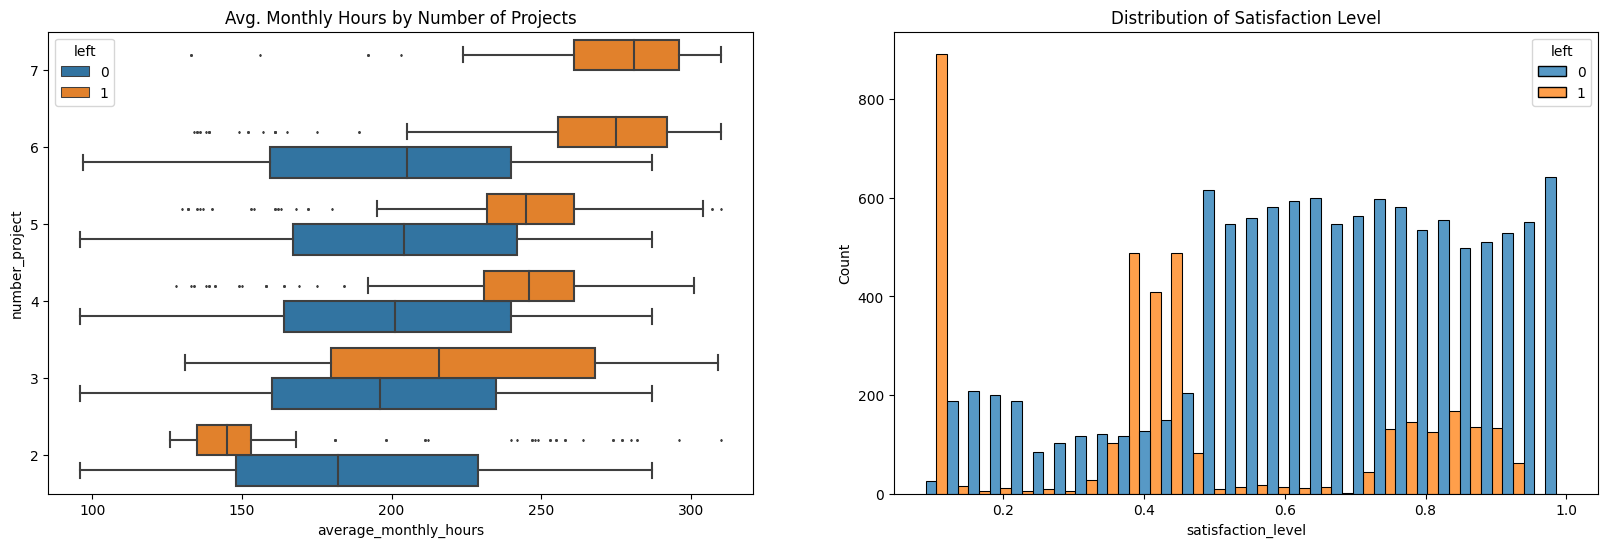

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))

# boxplot of  level avg. monthly hours & num of projects
sns.boxplot(data=data_subset, y='number_project', x='average_monthly_hours', hue='left',
            fliersize=1, 
            orient='h', 
            ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Avg. Monthly Hours by Number of Projects')

# histogram for distribution of satisfaction level
sns.histplot(data=data_subset, hue='left', x='satisfaction_level', multiple='dodge', ax=ax[1])
ax[1].set_title('Distribution of Satisfaction Level')

plt.show()

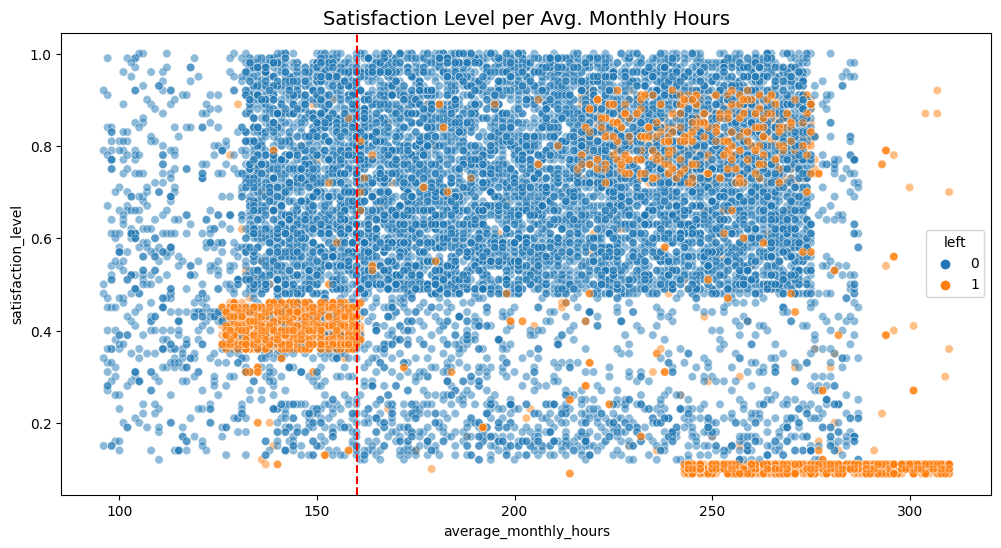

In [58]:
# scatterplot of `average_monthly_hours` versus `satisfaction_level`, comparing employees who stayed versus those who left
plt.figure(figsize=(12,6))
sns.scatterplot(data=data_subset, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.5)

# plot vertical line for 160 hrs. month (avg. 4 weeks at 40hrs)
plt.axvline(x=160, color = 'red', label='160 hrs/month', ls='--')


plt.title('Satisfaction Level per Avg. Monthly Hours', fontsize='14')
plt.show()

### Satisfaction Level, Hours Worked | Visual Insights

It might be natural that people who work on more projects would also work longer hours. This appears to be the case here.

1. When looking at the 'Distribution of Avg. Monthly Hours', it is interesting to observe that employees that stayed, work between ~125-280 monthly hours. However, there are increases in employees that leave for hours worked ~125-175 and ~225-280. Although there is a larger uptick in the number of employees that stayed for a range of hours, it is important to note that 160 hours is a quintessential month at 40hrs/week - most employees are working above this average. It seems evident that the uptick in employees leaving the company, coincide with approaching the edge of 160hrs., and then tailors off until reaching the mid-200s. Nonetheless, it should be worthwhile to probe the correlation of average-monthly-hours & whether employees leave or not.

2. While examining the 'Avg. Monthly Hours by Number of Projects', it is evident that for the majority of employees with the same number of projects (3-7), employees that left the company worked longer hours than those that stayed. It is interesting to note, that in the 'Distribution of Satisfaction Level', employees that stayed scored their satisfaction higher than those that left; it is corroborated by the heatmap, reflecting a (seemingly small, but apparently existing) negative coorelation between an employee's avg. monthly hours & their satisfaction level. This can seemingly be further corroborated by the observation of 100% employees with 7 projects left the company (and worked the most avg. monthly hours out of the two employee groups).

#### *Possible Recommendations/Next-Steps*

1. Investigating why there are certain employees who work longer monthly hours for the same number of projects, than those that work less hours. Is there correlation with the types of Projects; common/consistent hindrances in certain Projects? It may be worth conducting user interviews. 
2. Further investigating correlations & insights related to both an employee's average-monthly-hours and satisfaction levels.

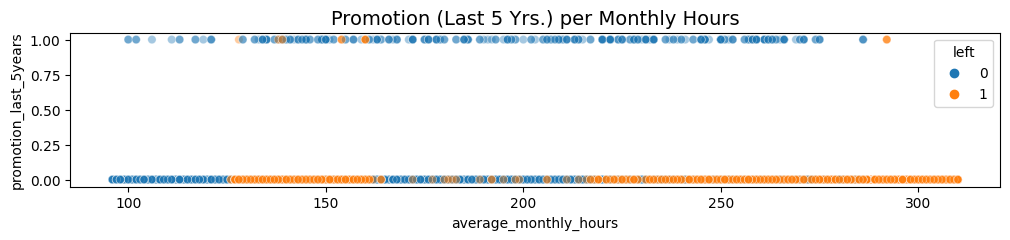

In [91]:
plt.figure(figsize=(12, 2))
sns.scatterplot(data=data_subset, x='average_monthly_hours', y='promotion_last_5years',
                hue='left',
                alpha=0.4 ) # alpha=transparency of points
plt.title('Promotion (Last 5 Yrs.) per Monthly Hours', fontsize='14');

### Promotion per Avg. Monthly Hours | Visual Insights

1. Looking at the 'Promotion (Last 5 Yrs.) per Monthly Hours, there is a trend observed in which employees that have not received a promotion in the last 5 years left the company; the employees that did receive a promotion, seem consistently more likely to stay with the company.
2. When compared with the overall population, it seems that few employees have been promoted within the last 5yrs.

In [92]:
data_subset.groupby('left')['satisfaction_level'].agg(['mean','median'])

,mean,median
left,,
0,0.666810,0.69
1,0.440098,0.41


### Satisfaction Level | Stastical Insights

1. Expectedly, the mean and median satisfaction scores of employees that left are lower than those of employees who stayed. Among employees who stayed, the mean satisfaction score appears to be slightly below the median score; this indicates that satisfaction levels among those who stayed are skewed to the left - as corroborated by the 'Distribution of Satisfaction Level' graph. 

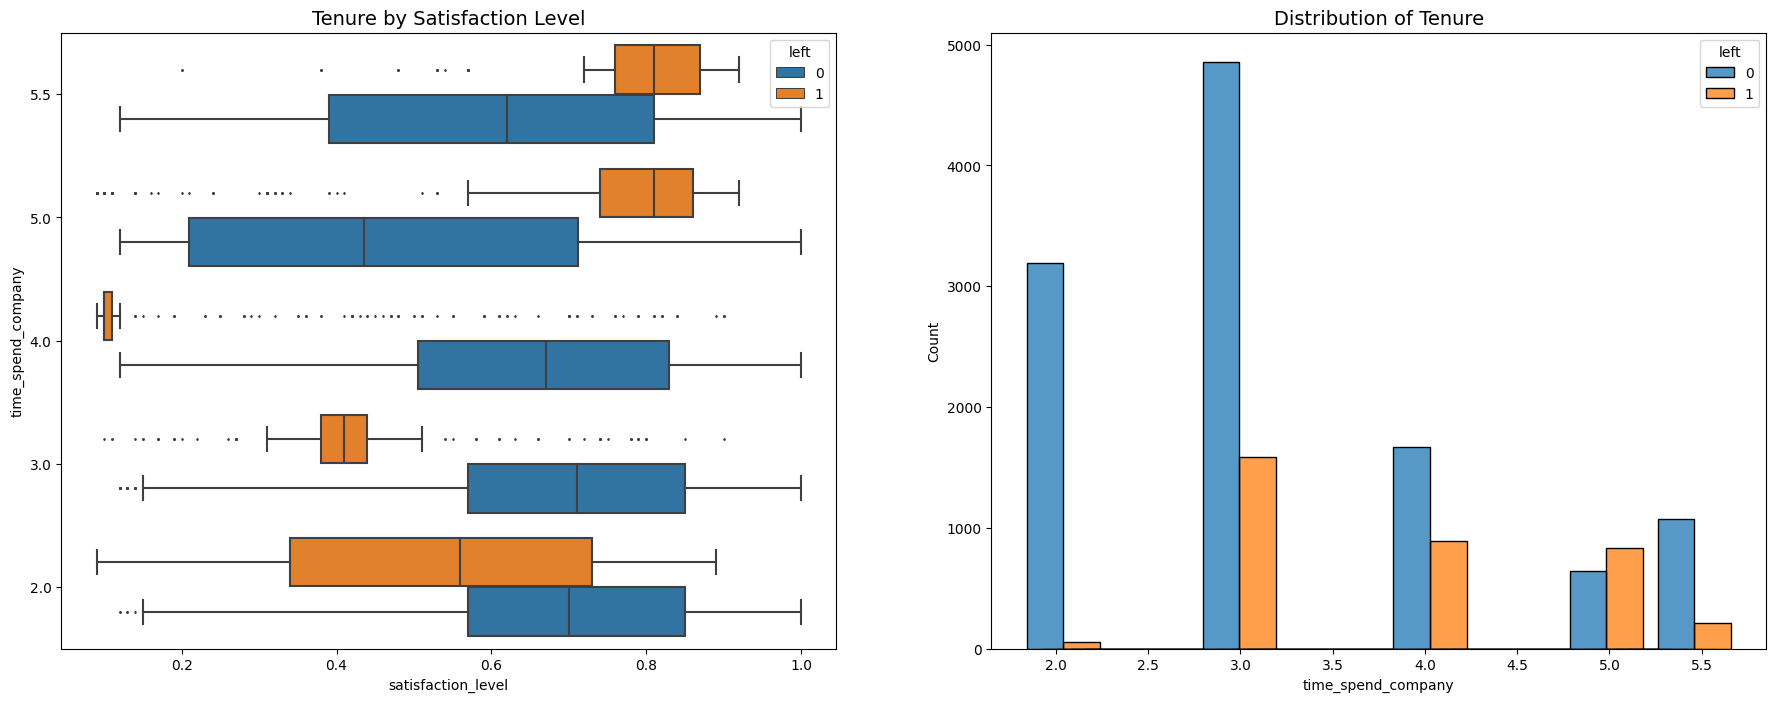

In [84]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# boxplot showing distributions of `satisfaction_level` by tenure, comparing employees who stayed versus those who left
sns.boxplot(data=data_subset, x='satisfaction_level', y='time_spend_company', hue='left', 
            orient="h",
            fliersize=1,
            ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Tenure by Satisfaction Level', fontsize='14')

# histogram showing distribution of tenure, comparing employees who stayed versus those who left
sns.histplot(data=data_subset, x='time_spend_company', hue='left', multiple='dodge',shrink=5, ax=ax[1])
ax[1].set_title('Distribution of Tenure', fontsize='14')

plt.show()

### Tenure by Satisfaction Level | Visual Insights

1. Reviewing 'Tenure by Satisfaction Level', employees that left fall into two general categories: (1) dissatisfied employees with shorter tenures and (2) very satisfied employees with longer tenures.
    * Employees that left after having been with the company for four years have unusually low satisfaction scores
2. A population of employees that have been with the company for 5-5.5 yrs have coinciding high satisfaction scores with shorter-tenured employees that also stayed.
3. 'Distribution of Tenure' reflects a smaller population of employees with longer tenures. This is important to note when looking at the high satisfaction levels in the box plot.

In [135]:
# define short-tenured employees
tenure_short = data_subset[data_subset['time_spend_company'] < 4]

# define long-tenured employees
tenure_long = data_subset[data_subset['time_spend_company'] > 3]

In [136]:
tenure_short.head(1)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,salary_enc
0,0.38,0.53,2,157,3.0,0,1,0,1


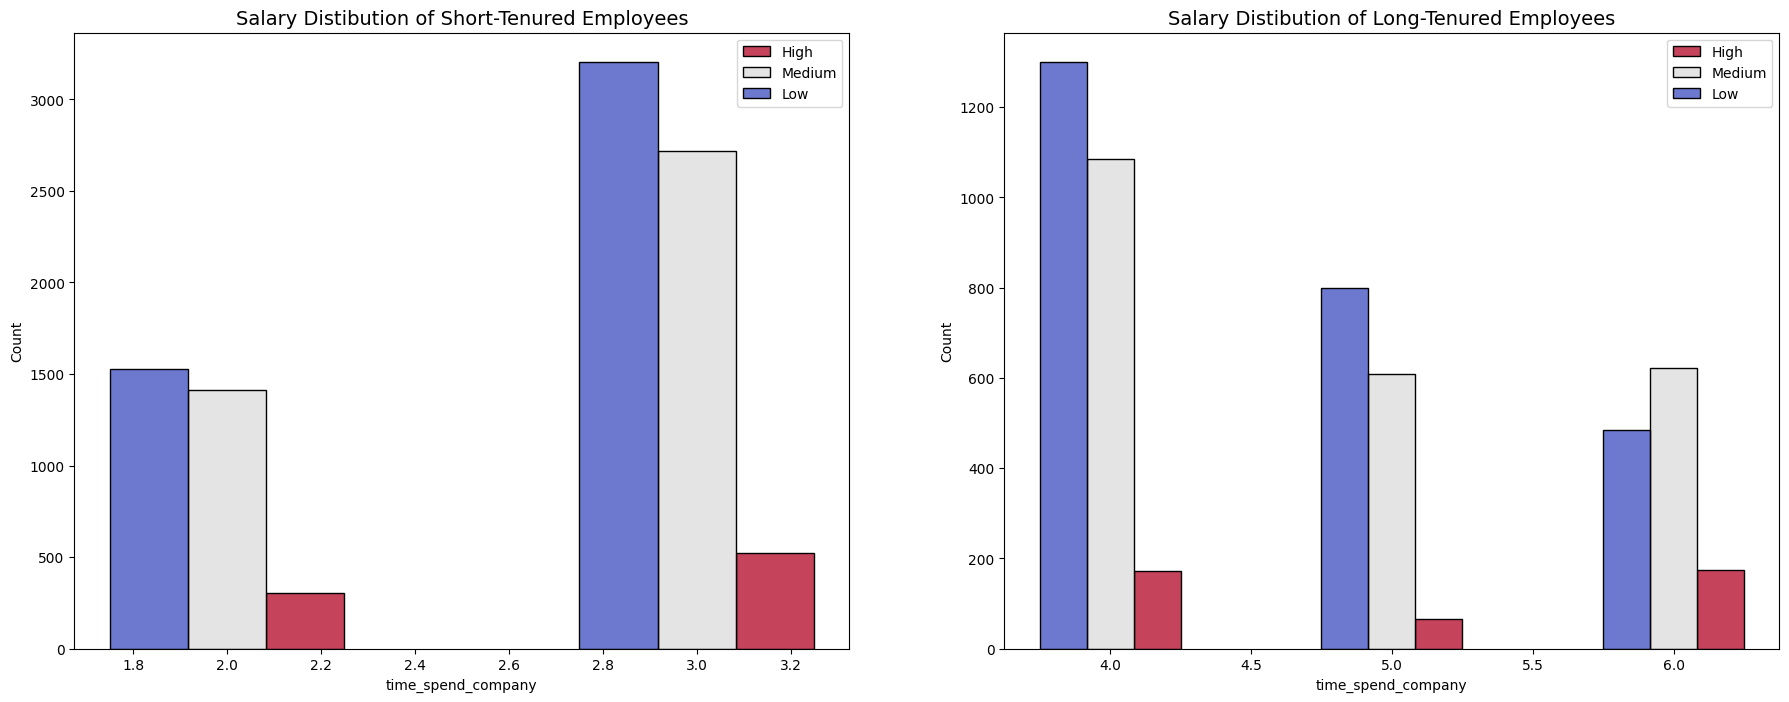

In [141]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# plot short-tenured histogram
sns.histplot(data=tenure_short, x='time_spend_company', palette='coolwarm', hue='salary_enc', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary Distibution of Short-Tenured Employees', fontsize='14')
ax[0].legend(['High', 'Medium', 'Low'])

# plot long-tenured histogram
sns.histplot(data=tenure_long, x='time_spend_company', palette='coolwarm', hue='salary_enc', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[1])
ax[1].set_title('Salary Distibution of Long-Tenured Employees', fontsize='14')
ax[1].legend(['High', 'Medium', 'Low'])

### Salary Distribution of Short-Tenured vs. Long-Tenured Employees | Visual Insights

1. The plots above show that longer-tenured employees were not disproportionately comprised of higher-paid employees. However, a low salary is observably ubiquitious among all tenures. 
    * **It may be worth re-encoding the 'salary' variable by dummy mapping, to view any relative correlation with salary levels and other variables** 

# Constructing Models
1. Determining which models are most appropriate
    * *Binary Classification:*
        * Logistic Regression, Decision Tree, Random Forest, Boosted Decision Tree
2. Constructing model(s)
3. Confirming model assumptions
    * *Logistic Regression model assumptions*
        * Outcome variable is categorical
        * Observations are independent of each other
        * No severe multicollinearity among X variables
        * No extreme outliers
        * Linear relationship between each X variable and the logit of the outcome variable
        * Sufficiently large sample size
4. Evaluating model results to determine how well a model fits the data

### Encoding 'departments' variable for modeling

In [144]:
# dummy mapping of departments
data_subset = pd.get_dummies(data, columns=['department']).copy()

In [145]:
# confirming dummy mapping
data_subset.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,salary,salary_enc,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3.0,0,1,0,low,1,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,5.5,0,1,0,medium,2,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4.0,0,1,0,medium,2,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5.0,0,1,0,low,1,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3.0,0,1,0,low,1,False,False,False,False,False,False,False,True,False,False


In [174]:
'''
Helper function that takes a model's name and a fitted model to create table with the provided model's name, f1 score, precision score, 
recall score and accuracy score.
'''
def make_results(model_name, f1_score, precision_score, recall_score, accuracy_score, index):
    table = pd.DataFrame({'Model' : model_name,
                  'F1' : f1_score,
                  'Precision' : precision_score,
                  'Recall' : recall_score,
                  'Accuracy' : accuracy_score
                 }, index=[index])
    return table

## (1) Logistic Regression Modeling


### 1a) Creating Training, Validation & Testing splits

***For X variable:***
* Dropped `last_evaluation` to account for multicollinearity
     * *It's also possible that evaluations aren't performed very frequently, in which case it would be useful to be able to predict employee retention without this feature*
* Dropped `salary` to exclude non-numerical data
* Dropped `left` to exclude target variable

In [146]:
# define X and y variables
y = data_subset['left']
X = data_subset.drop(columns=['left','last_evaluation', 'salary']).copy()

In [147]:
# create training and testing splits
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

In [148]:
# confirm training and testing shapes
X_tr.shape, X_test.shape, y_tr.shape, y_test.shape

((11999, 17), (3000, 17), (11999,), (3000,))

In [151]:
# confirm target variable proportions kept
print(f'Original: {data_subset.left.value_counts(normalize=True)}')
print(f'Training: {y_tr.value_counts(normalize=True)}')

Original: left
0    0.761917
1    0.238083
Name: proportion, dtype: float64
Training: left
0    0.761897
1    0.238103
Name: proportion, dtype: float64


In [156]:
# create training and validation splits
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=.25, random_state=42)

In [153]:
# confirm dimensions of splits
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((8999, 17), (3000, 17), (3000, 17), (8999,), (3000,), (3000,))

#### Split Considerations
1. Not able to stratify in validation split - may need to take this into consideration when evaluating final models; or we don't need to stratify again if we've already done it in our main train-test split?

### 1b) Creating & Fitting Model Object 

In [157]:
#instantiate model
clf = LogisticRegression(random_state=0, verbose=1, solver='liblinear')

In [158]:
%%time
# training logistic regresion model
log_reg_model = clf.fit(X_train, y_train)

[LibLinear]iter  1 act 1.177e+03 pre 1.124e+03 delta 5.061e-03 f 6.238e+03 |g| 4.660e+05 CG   1
iter  2 act 1.224e+01 pre 1.198e+01 delta 5.061e-03 f 5.061e+03 |g| 4.173e+04 CG   1
cg reaches trust region boundary
iter  3 act 5.324e+00 pre 5.324e+00 delta 2.024e-02 f 5.049e+03 |g| 1.670e+03 CG   2
cg reaches trust region boundary
iter  4 act 2.104e+01 pre 2.104e+01 delta 8.098e-02 f 5.043e+03 |g| 1.348e+03 CG   2
cg reaches trust region boundary
iter  5 act 8.062e+01 pre 8.061e+01 delta 3.239e-01 f 5.022e+03 |g| 1.658e+03 CG   2
cg reaches trust region boundary
iter  6 act 2.686e+02 pre 2.682e+02 delta 1.178e+00 f 4.942e+03 |g| 1.077e+03 CG   2
iter  7 act 4.612e+02 pre 4.206e+02 delta 1.298e+00 f 4.673e+03 |g| 5.696e+03 CG   2
iter  8 act 9.321e+00 pre 9.191e+00 delta 1.298e+00 f 4.212e+03 |g| 3.455e+04 CG   1
cg reaches trust region boundary
iter  9 act 2.624e+02 pre 2.737e+02 delta 1.422e+00 f 4.203e+03 |g| 8.318e+02 CG   3
iter 10 act 2.029e+00 pre 2.016e+00 delta 1.422e+00 f 3.940

In [159]:
# store predictions from model, based on validation set
y_pred = log_reg_model.predict(X_val)

In [160]:
# create confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=log_reg_model.classes_)

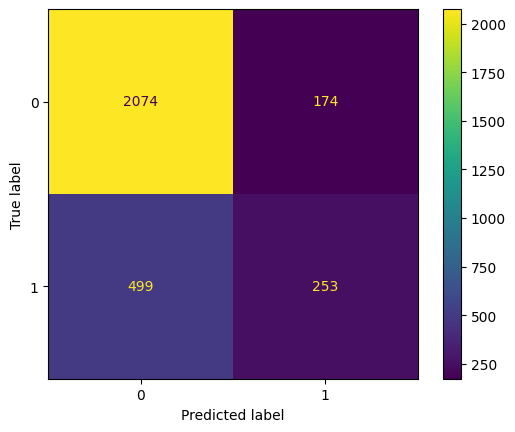

In [161]:
# display confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=log_reg_model.classes_)

disp.plot()
plt.show()

In [162]:
# calculate precision score
log_precision_score = precision_score(y_val, y_pred)
print(f'Precision Score: {log_precision_score: .4f}')

# calculate recall score
log_recall_score = recall_score(y_val, y_pred)
print(f'Recall Score: {log_recall_score: .4f}')

# calculate accuracy score
log_accuracy_score = accuracy_score(y_val, y_pred)
print(f'Accuracy Score: {log_accuracy_score: .4f}')

# calculate f1 score
log_f1_score = f1_score(y_val, y_pred)
print(f'F1 Score: {log_f1_score: .4f}')

Precision Score:  0.5925
Recall Score:  0.3364
Accuracy Score:  0.7757
F1 Score:  0.4292


#### **Model Eval.**

This model doesn't seem to preform that well when looking at the confusion matrix, confirmed by the evaluation statistics:

- Precision Score:  0.5925
- Recall Score:  0.3364
- Accuracy Score:  0.7757
- F1 Score:  0.4292

Although the *Accuracy* is decent at .7757, our *Recall* score is low at .3364 - indicating that this model has a high False Negative Rate. This model will likely predict employees won't leave when they actually will. When also taking into account the *F1 Score* of .4292, this may not be the best model to choose from.

In [176]:
# creating dataframe to store model results
log_results = make_results('Logistic Regression Model', log_f1_score, log_precision_score, log_recall_score, log_accuracy_score, 0)

log_results

,Model,F1,Precision,Recall,Accuracy
0,Logistic Regression Model,0.429177,0.592506,0.336436,0.775667


## (2) Boosted Decision Tree Modeling


In [177]:
# instantiate model object
xgb = XGBClassifier(objective='binary:logistic', random_state=0, verbose=1)

In [178]:
# set hyperparameters for checking
xgb_cv_params = {'n_estimators' : [5, 7, 9],
                 'max_depth' : [7, 10, 13],
                 'learning_rate' : [.01, .03, .2],
                 'subsample': [.70],
                 'colsample_bytree': [.2, .7]
                }

In [179]:
# set scoring metrics
scoring = {'recall', 'accuracy', 'precision', 'f1'}

In [180]:
# construct GridSearchCV
xgb_cv = GridSearchCV(xgb,
                      param_grid = xgb_cv_params,
                      scoring = scoring,
                      refit = 'f1',
                      cv = 5,
                      verbose = 1
                     )

In [181]:
%%time
# fit gridsearchcv to validation data
xgb_cv = xgb_cv.fit(X_train, y_train)
xgb_cv

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[22:00:09] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[22:00:10] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[22:00:10] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[22:00:10] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[22:00:10] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[22:00:10] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[22:00:10] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[22:00:10] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[22:00:10] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[22:00:10] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[22:00:10] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[22

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.2, 0.7],
                         'learning_rate': [0.01, 0.03, 0.2],
                         'max_depth': [7, 10, 13], 'n_estimators': [5, 7, 9],
                         'subsample': [0.7]},
             refit='f1', scoring={'precision', 'f1', 'recall', 'accuracy'},
             verbose=1)

In [182]:
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 7,
 'n_estimators': 9,
 'subsample': 0.7}

In [183]:
xgb_cv.best_score_

0.9363779530436845

#### Boosted Tree's Best Params

- 'colsample_bytree': 0.7
- 'learning_rate': 0.2
- 'max_depth': 7
- 'n_estimators': 9
- 'subsample': 0.7

#### Boosted Tree's Best Score
- .9363

### Re-Training & Validating | Best Params.

In [184]:
# re-instantiate model
xgb_best_fit = XGBClassifier(objective='binary:logistic', random_state=0, 
                             verbose=1,
                             colsample_bytree = 0.7,
                             learning_rate = 0.2,
                             max_depth = 7,
                             n_estimators = 9,
                             subsample = 0.7)

In [185]:
%%time
# refit best model params to validation data
xgb_best_fit = xgb_best_fit.fit(X_train, y_train)

[22:02:49] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

CPU times: user 263 ms, sys: 2.89 ms, total: 266 ms
Wall time: 83.6 ms


In [186]:
# store model predictions
y_pred = xgb_best_fit.predict(X_val)

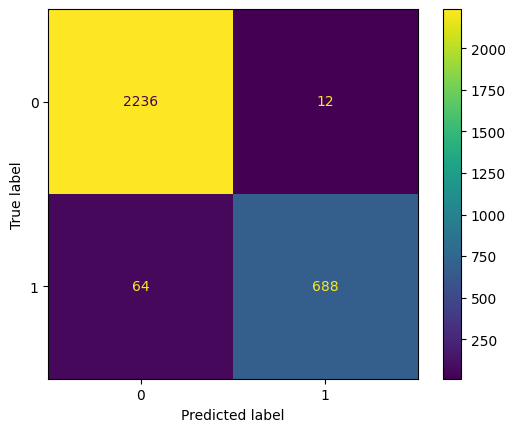

In [187]:
# create and display updated confusion matrix
xgb_cm = confusion_matrix(y_val, y_pred, labels=xgb_best_fit.classes_)
disp = ConfusionMatrixDisplay(xgb_cm, display_labels = xgb_best_fit.classes_)

disp.plot()
plt.show()

In [189]:
from sklearn import metrics
# calculate precision score
xgb_precision_score = metrics.precision_score(y_val, y_pred)
print(f'Precision Score: {xgb_precision_score: .4f}')

# calculate recall score
xgb_recall_score = metrics.recall_score(y_val, y_pred)
print(f'Recall Score: {xgb_recall_score: .4f}')

# calculate accuracy score
xgb_accuracy_score = metrics.accuracy_score(y_val, y_pred)
print(f'Accuracy Score: {xgb_accuracy_score: .4f}')

# calculate f1 score
xgb_f1_score = metrics.f1_score(y_val, y_pred)
print(f'F1 Score: {xgb_f1_score: .4f}')

Precision Score:  0.9829
Recall Score:  0.9149
Accuracy Score:  0.9747
F1 Score:  0.9477


### Plotting Identified Feature-Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

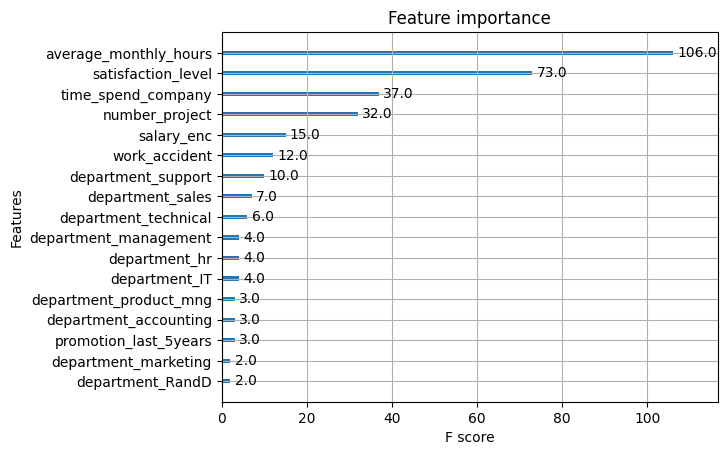

In [190]:
plot_importance(xgb_best_fit)

#### **Model Eval.**

This model seems to preform better than its Logistic Regression predecessor when looking at the confusion matrix, confirmed by evaluation statistics:

- Precision Score:  0.9829
- Recall Score:  0.9149
- Accuracy Score:  0.9747
- F1 Score:  0.9477

As shown in the feature importance, and noted during EDA, an employee's average monthly hours is an observable crucial crux to whether or not an employee leaves the company.

In [192]:
xgb_model_df = make_results('XGBoost Tuned Decision Tree', xgb_f1_score, xgb_precision_score, xgb_recall_score, xgb_accuracy_score, 1)
xgb_model_df

,Model,F1,Precision,Recall,Accuracy
1,XGBoost Tuned Decision Tree,0.947658,0.982857,0.914894,0.974667


In [202]:
# appending model results gathered hitherto
model_results = pd.concat([xgb_model_df, log_results])
model_results.sort_index()

,Model,F1,Precision,Recall,Accuracy
0,Logistic Regression Model,0.429177,0.592506,0.336436,0.775667
1,XGBoost Tuned Decision Tree,0.947658,0.982857,0.914894,0.974667


## (3) Random Forest Modeling


In [203]:
# setup hyperparameter listings
rf_params = {'n_estimators' : [100, 125, 150],
             'max_depth' : [5, 10, 30],
             'min_samples_split' : [2, 5, 10],
             'min_samples_leaf' : [1, 3],
             'max_samples' : [.5, .9]
            }

In [204]:
# instantiate Random Forest classifier
rf = RandomForestClassifier(random_state=0)

In [205]:
# construct GridSearchCV
rf_cv = GridSearchCV(rf, 
                     param_grid = rf_params,
                     scoring = scoring,
                     refit = 'f1',
                     cv = 5
                    )

In [206]:
%%time
# fit gridsearchcv to validation data
rf_cv.fit(X_train, y_train)

CPU times: user 6min 33s, sys: 1.43 s, total: 6min 34s
Wall time: 6min 34s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 10, 30], 'max_samples': [0.5, 0.9],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 125, 150]},
             refit='f1', scoring={'precision', 'f1', 'recall', 'accuracy'})

In [207]:
# get best parameters from cross validation
rf_cv.best_params_

{'max_depth': 30,
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [208]:
rf_cv.best_score_

0.9635653850760715

#### Random Forest's Best Params

- 'max_depth': 30,
- 'max_samples': 0.9,
- 'min_samples_leaf': 1,
- 'min_samples_split': 2,
- 'n_estimators': 150

#### Boosted Tree's Best Score
- .9635

### Re-Training & Validating | Best Params.

In [209]:
# instantiate model with best params found
rf_best_model = RandomForestClassifier(n_estimators=150,
                                       min_samples_split=2,
                                       min_samples_leaf=1,
                                       max_samples=0.9,
                                       max_depth=30
                                      )

In [210]:
%%time
# retraining model with best params
rf_best_model.fit(X_train, y_train)

CPU times: user 1.3 s, sys: 4 ms, total: 1.31 s
Wall time: 1.31 s


RandomForestClassifier(max_depth=30, max_samples=0.9, n_estimators=150)

In [211]:
# storing model predictions
y_pred = rf_best_model.predict(X_val)

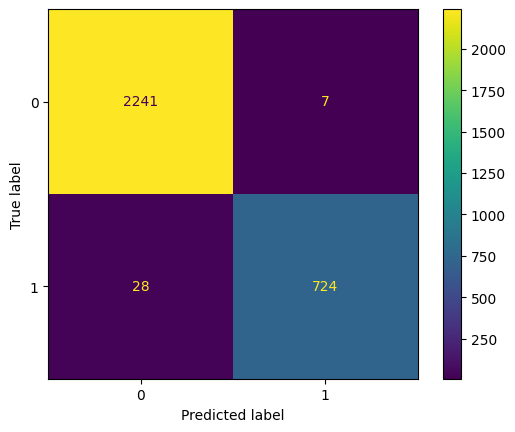

In [212]:
# construct and display updated confusion matrix
rf_cm = confusion_matrix(y_val, y_pred, labels = rf_best_model.classes_)
disp = ConfusionMatrixDisplay(rf_cm, display_labels = rf_best_model.classes_)

disp.plot()
plt.show()

In [214]:
from sklearn import metrics

# calculate precision score
rf_precision_score = metrics.precision_score(y_val, y_pred)
print(f'Precision Score: {rf_precision_score: .4f}')

# calculate recall score
rf_recall_score = metrics.recall_score(y_val, y_pred)
print(f'Recall Score: {rf_recall_score: .4f}')

# calculate accuracy score
rf_accuracy_score = metrics.accuracy_score(y_val, y_pred)
print(f'Accuracy Score: {rf_accuracy_score: .4f}')

# calculate f1 score
rf_f1_score = metrics.f1_score(y_val, y_pred)
print(f'F1 Score: {rf_f1_score: .4f}')

Precision Score:  0.9904
Recall Score:  0.9628
Accuracy Score:  0.9883
F1 Score:  0.9764


#### **Model Eval.**

This model seems to preform the best so far when examining its confusion matrix & evaluation statistics:

- Precision Score:  0.9904
- Recall Score:  0.9628
- Accuracy Score:  0.9883
- F1 Score:  0.9764

In [215]:
# create dataframe of evaluation metrics for tuned RF model
rf_results_df = make_results('Tuned Random Forest',rf_f1_score,rf_precision_score,rf_recall_score,rf_accuracy_score, 2)
rf_results_df

,Model,F1,Precision,Recall,Accuracy
2,Tuned Random Forest,0.976399,0.990424,0.962766,0.988333


In [216]:
# appending model results gathered hitherto
model_results = pd.concat([rf_results_df, model_results])
model_results.sort_index()

,Model,F1,Precision,Recall,Accuracy
0,Logistic Regression Model,0.429177,0.592506,0.336436,0.775667
1,XGBoost Tuned Decision Tree,0.947658,0.982857,0.914894,0.974667
2,Tuned Random Forest,0.976399,0.990424,0.962766,0.988333


## 4) Champion Model

### Selecting Champion Model
From the tracked results of the modeling evaluation metrics, the `Tuned Random Forest` model leads the group with higher F1, Precision, and Accuracy scores. 

F1 score as our main measure - the balance of precision and recall - for choosing a model seems to be the most applicable for this context; assuming the company wants to both accurately identify employees which may leave the company & reliably be consistent in the predictions.

**The Tuned Random Forest model is selected as the 'Champion Model', to be re-trained on the greater training data (validation inclusive), and then evaluated based on the results from our hold-out test data.**

*Dependent on company priorities, the `XGBoost Tuned Decision Tree` model could also have been chosen based on its metrics*

### Re-Training Model *(with validation data included in training set)*

In [217]:
%%time
# retrain random forest model
rf_best_model.fit(X_tr, y_tr)

CPU times: user 1.62 s, sys: 1.96 ms, total: 1.62 s
Wall time: 1.62 s


RandomForestClassifier(max_depth=30, max_samples=0.9, n_estimators=150)

In [218]:
# store model predictions
y_pred = rf_best_model.predict(X_test)

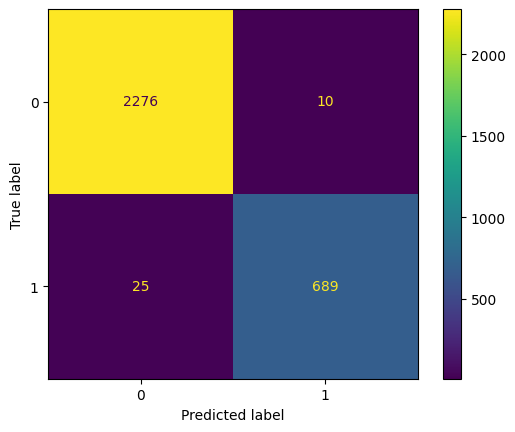

In [219]:
# construct and display champion model confusion matrix
rf_champ_cm = confusion_matrix(y_test, y_pred, labels = rf_best_model.classes_) 
disp = ConfusionMatrixDisplay(rf_champ_cm, display_labels = rf_best_model.classes_)

disp.plot()
plt.show()

In [220]:
from sklearn import metrics

# calculate precision score
rfchamp_precision_score = metrics.precision_score(y_test, y_pred)
print(f'Precision Score: {rfchamp_precision_score: .4f}')

# calculate recall score
rfchamp_recall_score = metrics.recall_score(y_test, y_pred)
print(f'Recall Score: {rfchamp_recall_score: .4f}')

# calculate accuracy score
rfchamp_accuracy_score = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {rfchamp_accuracy_score: .4f}')

# calculate f1 score
rfchamp_f1_score = metrics.f1_score(y_test, y_pred)
print(f'F1 Score: {rfchamp_f1_score: .4f}')

Precision Score:  0.9857
Recall Score:  0.9650
Accuracy Score:  0.9883
F1 Score:  0.9752


#### **Champion Model Eval.**

See evaluation statistics below:

- Precision Score:  0.9857
- Recall Score:  0.9650
- Accuracy Score:  0.9883
- F1 Score:  0.9752

# Execute
- Interpreting model performance and results
- Recommending actionable steps for stakeholders (HR Dept.)



# Summary of Results

After re-training our Champion model, *Tuned Random Forest*, it achieved a *Precision* of 98.57%, *Recall* of 96.50%, *Accuracy* of 98.83%, and *F1* of 97.52%.

## *Stakeholder Recommendations*
1. Reduce/cap the number of projects assigned to employees. There is notable evidence that a large number of projects leads to employee churn. Further investigation into why there are certain employees with a large number of projects may be warranted; an initial area for investigation being if this is due to employees with longer tenure undertaking more responsibility. 
2. Further investigation into why there are certain employees who work longer monthly hours for the same number of projects as other employees. Is there correlation with the types of Projects; common/consistent hindrances in certain Projects; high-complexity? It may be worth conducting user interviews and depending on results, reconstructing how projects are assigned to employees - e.g., accounting for the number of projects an employee has based on the complexity of projects. 
3. Promoting employees more frequently (possibly at 3 years), reviewing the process/criteria for promotion, and investigating familiarity with overtime & time-off policy. Employees should be familiar with overtime and PTO policies to avoid burnout, decreased satisfaction levels, and an enticement to leave the company. Increasing the frequency of promotion may also aid in validating employees for the long hours they work. Also recommend further investigation into salary and tenure.

## *Analysis Results*
1. Employees may be overworked. Observed in the data, there is a strong correlation with employee churn and large amounts of hours worked. This is also noticed in lower satisfaction scores among employees with higher-than-average monthly hours.
    * There was a sizeable group of employees who worked ~240–315 hours per month, ultimately leaving the company. 160 hours is a typical month for 40hrs/week. 315 hours per month is over 75 hours per week for a whole year. It's likely this population's satisfaction levels being close to 0 is related.
2. Employees are not consistently being promoted. Employee churn may be high due to employees not feeling rewarded for the long hours they are observed having worked. This is evident by a large population of employees leaving the company after not having been promoted within the last 5 years; contrasted with employees that stayed & were promoted within the last 5 years.
    * Employees that left the company after 4 years were observed as being extremely dissatisfied. This could be associated with having worked long hours with no promotion, and expecting to continue working long hours for the foreseeable future.
3. There are employees with the same amount of projects that work longer hours than others, leading to employee churn. 
    * A population of employees that left with more "normal" working hours, had observed satisfaction levels around 0.4. It's difficult to speculate why they might have left without further investigation. It's possible they felt pressured to work more, considering so many of their peers worked more. And that pressure could have lowered their satisfaction levels & decision to leave.
    * A population of employees that stayed when working above average hours per month, and had satisfaction levels ranging above .4. This is worth investigating more.

 

## *Next Steps*
1. Using our `Tuned Random Forest` model for predicting whether or not an employee will leave the company. 
2. Investigating areas mentioned in above summary. 
3. Any further discussion needed on recommendations given. 